### Sentiment Analysis Intro
We have a dataset of combined reviews for films from IMDB and Rotten Tomatoes.

- **Task**: build a model that can predict a sentiment (positive/negative) based on a user's review.

In [38]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import (
    Input, Lambda, Dropout,
    Activation, Dense, Embedding,
    SimpleRNN, Conv1D, GlobalMaxPooling1D,
    MaxPooling1D, LSTM, Flatten, Bidirectional, Layer, merge
)
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical
from keras import backend as K, initializers

# from gensim import KeyedVectors
from tqdm import tqdm

In [52]:
%env KERAS_BACKEND=theano

env: KERAS_BACKEND=theano


### Data Downloading

In [39]:
train_df = pd.read_csv('/home/jovyan/work/data_sets/uds_sentiment_analysis/movie_reviews_train.csv', header=[0])
test_df = pd.read_csv('/home/jovyan/work/data_sets/uds_sentiment_analysis/movie_reviews_test.csv', header=[0])

print('N Unique Comments (Train): ', train_df.shape[0])
print('N Unique Comments (Test): ', test_df.shape[0])

train_df.head()

N Unique Comments (Train):  152610
N Unique Comments (Test):  10660


,label,text
0,1,"To an entire generation of filmgoers, it just ..."
1,1,Pixar classic is one of the best kids' movies ...
2,1,Apesar de representar um imenso avanço tecnoló...
3,1,"When Woody perks up in the opening scene, it's..."
4,1,Introduced not one but two indelible character...


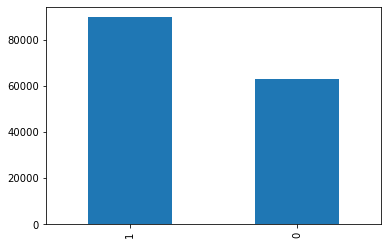

In [40]:
# class distribution
train_df['label'].value_counts().plot(kind='bar')
plt.show()

- **Not heavily imbalanced**

### Data Preprocessing
**Text Preprocessing**

In [41]:
RANDOM_SEED = 23

# parameters for vocab and embeddings
VOCAB_SIZE = 20_000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 32

In [42]:
tweet_tokenizer = TweetTokenizer()

negatives = {
    "didn't": "didn_`_t",
    "couldn't": "couldn_`_t",
    "can't": "can_`_t",
    "don't": "don_`_t",
    "wouldn't": "wouldn_`_t",
    "doesn't": "doesn_`_t",
    "wasn't": "wasn_`_t",
    "weren't": "weren_`_t",
    "shouldn't":"shouldn_`_t",
    "isn't": "isn_`_t",
    "aren't": "aren_`_t",
}

def preprocess(text):
    text = text.lower()
    text = text.replace('<br />', ' ')
    text = ' '.join(tweet_tokenizer.tokenize(text))
    for k, v in negatives.items():
        text = text.replace(k, v)
    return text

In [43]:
# test "preprocess" function
text = """
A sentimental crowd-pleaser, well-directed by Le McCarey,
this tale about a priest (Bing Crosby) assigned to a problematic
parish was so popular that Paramount reteamed the same players for
The Bells of St. Mary's.
"""

preprocessed_text = preprocess(text)
preprocessed_text

"a sentimental crowd-pleaser , well-directed by le mccarey , this tale about a priest ( bing crosby ) assigned to a problematic parish was so popular that paramount reteamed the same players for the bells of st . mary's ."

In [44]:
%%time 

# preprocess train and test
train_df.loc[:, 'prep_text'] = train_df['text'].map(preprocess)
test_df.loc[:, 'prep_text'] = test_df['text'].map(preprocess)

CPU times: user 1min 47s, sys: 103 ms, total: 1min 47s
Wall time: 1min 47s


**Text Tokenization**

In [45]:
# tokenize train preprocessed text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='"#$%&()*+-/:;<=>@[\\]^{|}~\t\n,.')
tokenizer.fit_on_texts(train_df['prep_text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 132175 unique tokens.


**Text Encoding**

In [46]:
# encode train and test data
sequences_train = tokenizer.texts_to_sequences(train_df['prep_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['prep_text'])

In [47]:
print('Preprocessed Text: \n', train_df['prep_text'].iloc[0])
print('\nEncoded Text: \n', sequences_train[0])

Preprocessed Text: 
 to an entire generation of filmgoers , it just might represent the most significant leap in storytelling that they will ever see ...

Encoded Text: 
 [5, 28, 471, 1779, 4, 13861, 8, 43, 222, 4365, 1, 76, 2644, 5700, 7, 1986, 11, 38, 80, 120, 70]


In [48]:
# now each new commet can be encoded into numbers using our tokenizer
# Each sentence must be inclosed into a list!, otherwise, wrong tokens 
user_review = ["""
I liked the moview, awesome!
"""]
user_review_enc = tokenizer.texts_to_sequences(user_review)
user_review_enc

[[10, 476, 1]]

**Padding**
- Texts that have less len that `MAX_SEQUENCE_LENGTH` they are padded whereas those that exceed `MAX_SEQUENCE_LENGTH` are trimmed (we can n tones from the beginning or from the end -> from the end is default behaviour). 
- To proper define `MAX_SEQUENCE_LENGTH` we can look at texts sequence disribution and choose optimal value (e.g. `Q3` from boxplot)
- `Fixed Input Size:` Padding ensures that all sequences have the same length, allowing them to be processed efficiently in batches.
- `Efficient Batch Processing:` NN often require inputs to be batched together for efficient computation, especially for GPUs. Padding ensures that all sequences within a batch have the same length, making it possible to stack them into a single tensor.
- `Padding Values Masking:` Most of the time padded values **are masked during training to ignore them during computation/backpropagation. This prevents the model from considering padding tokens as meaningful input.

In [49]:
# pad train/test 
sequences_train_pad = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
sequences_test_pad = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [50]:
print('Padded Sequence: \n', pad_sequences(user_review_enc, maxlen=MAX_SEQUENCE_LENGTH))

Padded Sequence: 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  10 476   1]]


**Train/Test Split**

In [51]:
X_train, X_test = sequences_train_pad, sequences_test_pad
y_train, y_test = train_df['label'], test_df['label']

# convert labels to categorical
labels = to_categorical(np.asarray(y_train))
print('Shape of Train Tensor:', X_train.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Train Tensor: (152610, 30)
Shape of Label Tensor: (152610, 2)


### Model Training 
Let's train a simple NN model (not a recurrent one). The NN will have the following architecture:
- Embedding Layer (Input)
- 2 Hinned Layers (Hidden)
- 1 Output Layer (Output)

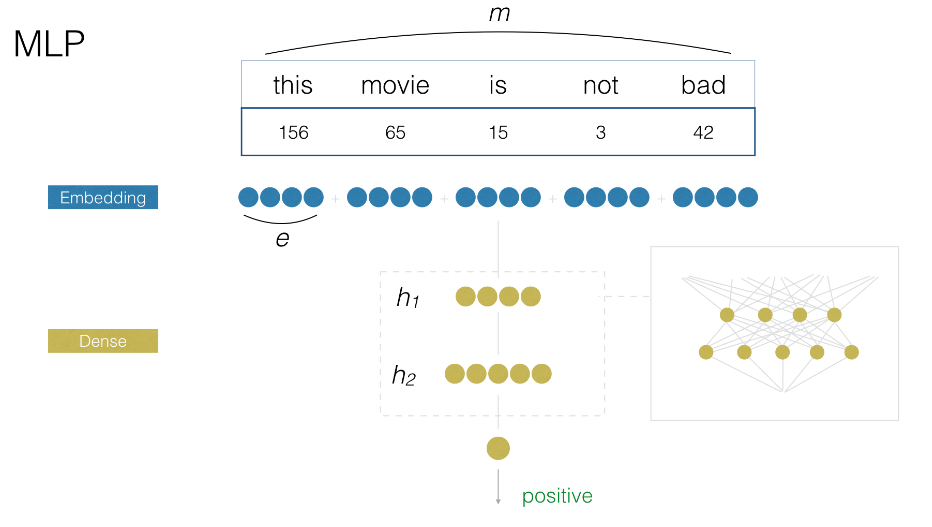

- Keras is a high-level neural networks API that supports multiple backend engines, such as TensorFlow, Theano, and Microsoft Cognitive Toolkit (CNTK). By default, Keras uses TensorFlow as its backend. However, in some cases, you may want to use Theano instead of TensorFlow for various reasons, such as compatibility with existing code or specific features provided by Theano

In [119]:
# NN params
H1 = 128
H2 = 128

simple_nn = Sequential()
simple_nn.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
simple_nn.add(Flatten())
simple_nn.add(Dense(H1, activation='relu'))
simple_nn.add(Dense(H2, activation='relu'))
simple_nn.add(Dense(1, activation='sigmoid'))
simple_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [121]:
%%time

# train model
simple_nn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test)
)

Epoch 1/5
1193/1193 - 8s - loss: 0.4756 - accuracy: 0.7641 - val_loss: 0.4268 - val_accuracy: 0.8029
Epoch 2/5
1193/1193 - 8s - loss: 0.3451 - accuracy: 0.8436 - val_loss: 0.4236 - val_accuracy: 0.8094
Epoch 3/5
1193/1193 - 8s - loss: 0.1937 - accuracy: 0.9197 - val_loss: 0.5543 - val_accuracy: 0.7865
Epoch 4/5
1193/1193 - 8s - loss: 0.0891 - accuracy: 0.9657 - val_loss: 0.8589 - val_accuracy: 0.7881
Epoch 5/5
1193/1193 - 9s - loss: 0.0502 - accuracy: 0.9815 - val_loss: 1.0938 - val_accuracy: 0.7823
CPU times: user 2min 19s, sys: 25.8 s, total: 2min 45s
Wall time: 41.6 s


**Results Analysis**
- Even 3 epochs is sufficient for the model. Adding more epochs doesn't improve the performance and leads to overfitting. 
- Regularization may work out to improve performance (e.g. add Droput)
- Elu instead of ReLU may improve the performance

In [148]:
def make_prediction(model, text):
    text = preprocess(text)
    text_seq = tokenizer.texts_to_sequences([text])
    text_seq = pad_sequences(text_seq, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict(text_seq)[0][0]

In [174]:
# test model
user_reviews = pd.Series([
    'Awesome film',
    'This film is bad!',
    'This film is not bad',
    'I think the movie is good',
    "I don't think the movie is good"
])

# all results will store in final df
benchmark_df = pd.DataFrame()

for review in user_reviews:
    review_proba = make_prediction(simple_nn, review)
    row = {
        'model': 'simple_nn',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df

,model,review,pred_proba
0,simple_nn,Awesome film,0.997692
1,simple_nn,This film is bad!,0.009173
2,simple_nn,This film is not bad,0.283707
3,simple_nn,I think the movie is good,0.990358
4,simple_nn,I don't think the movie is good,0.932783


**Results Analysis**
- The model can correctly predict simple reviews
- Doesn't capture word order! Have a look at "This film is not bad"

### Simple RNN
The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations.

Training a RNN is similar to training a traditional Neural Network. We also use the backpropagation algorithm, but with a little twist. Because the parameters are shared by all time steps in the network, the gradient at each output depends not only on the calculations of the current time step, but also the previous time steps.

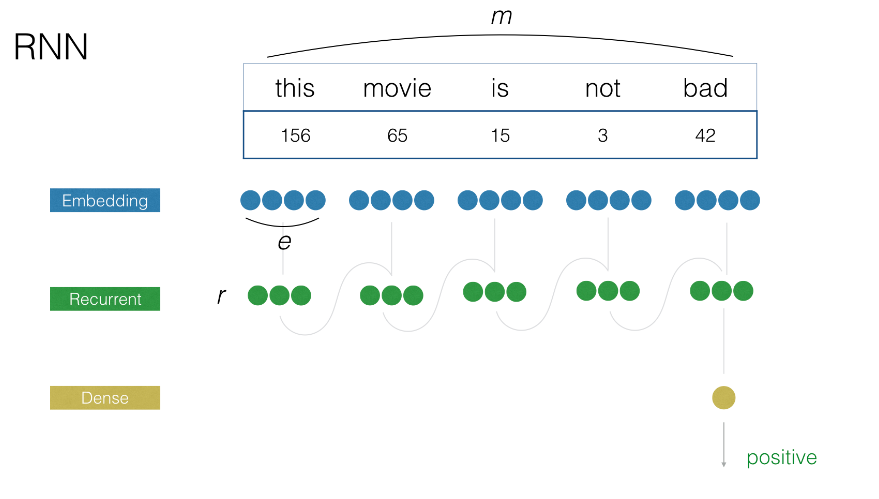

**Important**
- In Recurrent Layer we have only 3 neurons (not 15)! Weights in the layer are the same. The difference is when we take second word as input we also take previous word.
- **This architecture models sentences reading from humans** (i.e. when we read next word we have context of n-previous words).
- The main bottleneck: gardients explotion and vanishing (during backpropagation the gradint is updated N times!). In practice it means that the model **will fail to learn lengthy dependecy**


In [163]:
simple_rnn = Sequential()
simple_rnn.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
simple_rnn.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
simple_rnn.add(Dropout(0.2))
simple_rnn.add(Dense(1, activation='sigmoid'))
simple_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [172]:
%%time

# train model
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True, 
    verbose=1
)

callback_history = simple_rnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
1193/1193 - 46s - loss: 0.3026 - accuracy: 0.8749 - val_loss: 0.5268 - val_accuracy: 0.7763
Epoch 2/10
1193/1193 - 47s - loss: 0.2880 - accuracy: 0.8813 - val_loss: 0.5381 - val_accuracy: 0.7739
Epoch 3/10
1193/1193 - 43s - loss: 0.2747 - accuracy: 0.8871 - val_loss: 0.5489 - val_accuracy: 0.7769
Epoch 4/10
1193/1193 - 41s - loss: 0.2651 - accuracy: 0.8918 - val_loss: 0.5504 - val_accuracy: 0.7839
Epoch 5/10
1193/1193 - 40s - loss: 0.2543 - accuracy: 0.8968 - val_loss: 0.5577 - val_accuracy: 0.7807
Epoch 6/10
1193/1193 - 40s - loss: 0.2441 - accuracy: 0.9010 - val_loss: 0.5834 - val_accuracy: 0.7692
Epoch 7/10
1193/1193 - 41s - loss: 0.2394 - accuracy: 0.9034 - val_loss: 0.6068 - val_accuracy: 0.7681
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
CPU times: user 11min 59s, sys: 4min 24s, total: 16min 24s
Wall time: 4min 58s


In [175]:
for review in user_reviews:
    review_proba = make_prediction(simple_rnn, review)
    row = {
        'model': 'simple_rnn',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df[benchmark_df['model'] == 'simple_rnn']

,model,review,pred_proba
5,simple_rnn,Awesome film,0.917921
6,simple_rnn,This film is bad!,0.148860
7,simple_rnn,This film is not bad,0.074618
8,simple_rnn,I think the movie is good,0.436148
9,simple_rnn,I don't think the movie is good,0.298236


### LSTM
It's a special kind of RNN **capable of learning long-term dependencies.** They work tremendously well on a large variety of problems. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior. 

In [177]:
simple_lstm = Sequential()
simple_lstm.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
simple_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
simple_lstm.add(Dropout(0.2))
simple_lstm.add(Dense(1, activation='sigmoid'))
simple_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [178]:
%%time

simple_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
1193/1193 - 93s - loss: 0.4752 - accuracy: 0.7678 - val_loss: 0.4310 - val_accuracy: 0.7997
Epoch 2/10
1193/1193 - 90s - loss: 0.3839 - accuracy: 0.8239 - val_loss: 0.3974 - val_accuracy: 0.8172
Epoch 3/10
1193/1193 - 90s - loss: 0.3415 - accuracy: 0.8448 - val_loss: 0.4021 - val_accuracy: 0.8223
Epoch 4/10
1193/1193 - 91s - loss: 0.3084 - accuracy: 0.8626 - val_loss: 0.4038 - val_accuracy: 0.8221
Epoch 5/10
1193/1193 - 95s - loss: 0.2815 - accuracy: 0.8761 - val_loss: 0.4275 - val_accuracy: 0.8166
Epoch 6/10
1193/1193 - 94s - loss: 0.2576 - accuracy: 0.8883 - val_loss: 0.4364 - val_accuracy: 0.8190
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
CPU times: user 38min 29s, sys: 10min 50s, total: 49min 19s
Wall time: 9min 12s


In [179]:
for review in user_reviews:
    review_proba = make_prediction(simple_lstm, review)
    row = {
        'model': 'simple_lstm',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df[benchmark_df['model'] == 'simple_lstm']

,model,review,pred_proba
10,simple_lstm,Awesome film,0.945008
11,simple_lstm,This film is bad!,0.059084
12,simple_lstm,This film is not bad,0.405407
13,simple_lstm,I think the movie is good,0.708787
14,simple_lstm,I don't think the movie is good,0.448138


**Important**
- It's not recommended dropping stop words for LSTM or RNN. Stop words for RNN can contain important information in a sequence.

### Pre-Trained Embeddings
Model performance can be improved by using pre-trained embeddings. Any pre-trained embeddings can be used.

In [183]:
# initialize pre-trained embeddings
w2v_google = KeyedVectors.load_word2vec_format(
    '/home/jovyan/work/data_sets/uds_sentiment_analysis/GoogleNews-vectors-negative300.bin',
    binary=True
)
w2v_google.init_sims(replace=True)

/tmp/ipykernel_37/3842476817.py:2: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_google.init_sims(replace=True)


In [191]:
def get_embedding(word2vec_model, word):
    """
    Gets word embedding from pre-trained model.
    If the word is missing, return zero vector.
    """
    try:
        return word2vec_model.word_vec(word)
    except KeyError:
        return np.zeros(word2vec_model.vectors.shape[1])


In [194]:
# get embedding matrix for tokens from VOCAB 
embedding_weights_google = np.zeros((VOCAB_SIZE, w2v_google.vectors.shape[1]))
for word, i in tqdm(word_index.items(), total=VOCAB_SIZE, desc="Getting Google Embeddings"):
    if i >= VOCAB_SIZE:
        continue
    embedding_weights_google[i] = get_embedding(w2v_google, word)

Getting Google Embeddings:   0%|                                                              | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_37/1729958214.py:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return word2vec_model.word_vec(word)
Getting Google Embeddings: 132175it [00:00, 446534.64it/s]                                                              


In [198]:
w2v_lstm = Sequential()
w2v_lstm.add(
    Embedding(
        VOCAB_SIZE, w2v_google.vectors.shape[1],
        mask_zero=True,
        weights=[embedding_weights_google],
        trainable=False
    )
)
w2v_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
w2v_lstm.add(Dropout(0.2))
w2v_lstm.add(Dense(1, activation='sigmoid'))
w2v_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
%%time

w2v_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
1193/1193 - 152s - loss: 0.5169 - accuracy: 0.7388 - val_loss: 0.4631 - val_accuracy: 0.7815
Epoch 2/10
1193/1193 - 144s - loss: 0.4709 - accuracy: 0.7678 - val_loss: 0.4486 - val_accuracy: 0.7826
Epoch 3/10
1193/1193 - 134s - loss: 0.4504 - accuracy: 0.7818 - val_loss: 0.4272 - val_accuracy: 0.8006
Epoch 4/10
1193/1193 - 134s - loss: 0.4363 - accuracy: 0.7906 - val_loss: 0.4038 - val_accuracy: 0.8096
Epoch 5/10
1193/1193 - 133s - loss: 0.4224 - accuracy: 0.7993 - val_loss: 0.3900 - val_accuracy: 0.8166
Epoch 6/10
1193/1193 - 135s - loss: 0.4112 - accuracy: 0.8057 - val_loss: 0.3915 - val_accuracy: 0.8199
Epoch 7/10
1193/1193 - 130s - loss: 0.4012 - accuracy: 0.8121 - val_loss: 0.3894 - val_accuracy: 0.8212
Epoch 8/10
1193/1193 - 131s - loss: 0.3931 - accuracy: 0.8164 - val_loss: 0.3795 - val_accuracy: 0.8256
Epoch 9/10
1193/1193 - 130s - loss: 0.3846 - accuracy: 0.8205 - val_loss: 0.3627 - val_accuracy: 0.8359
Epoch 10/10
1193/1193 - 131s - loss: 0.3780 - accuracy: 0.8248 -

In [200]:
for review in user_reviews:
    review_proba = make_prediction(w2v_lstm, review)
    row = {
        'model': 'w2v_lstm',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df[benchmark_df['model'] == 'w2v_lstm']

,model,review,pred_proba
15,w2v_lstm,Awesome film,0.945008
16,w2v_lstm,This film is bad!,0.059084
17,w2v_lstm,This film is not bad,0.405407
18,w2v_lstm,I think the movie is good,0.708787
19,w2v_lstm,I don't think the movie is good,0.448138


### Bidirectional LSTM
Enhances the context available to the algorithm by processing data in **both forward and backward directions.** This architecture is especially useful in tasks where the all-round context (past and future information) is crucial for understanding or predicting the current element in the sequence.

Bidirectional LSTM consists of two LSTM Layers:
-  One layer processes the sequence from start to finish
- Another layer to processes the sequence from finish to start

This setup allows the network to learn from the past (forward states) and the future (backward states) simultaneously. Outputs from two layers can be processed in the following ways:
- `Concatenation:` The most common method where outputs from both layers are concatenated. This method preserves information from both past and future.
- `Summation:` The outputs are added together, which can help in reducing the dimensionality but might lose some context.
- `Averaging:` Outputs are averaged, potentially smoothing over details.
- `Max pooling:` The maximum output at each time step from either direction is taken, focusing on the strongest signals.

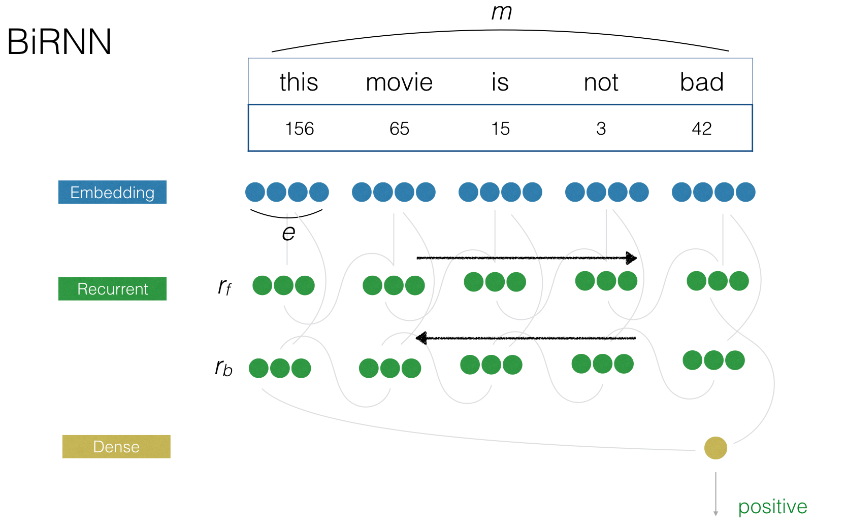

In [204]:
bdir_lstm = Sequential()
bdir_lstm.add(
    Embedding(
        VOCAB_SIZE, w2v_google.vectors.shape[1],
        mask_zero=True,
        weights=[embedding_weights_google],
        trainable=False
    )
)
bdir_lstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
bdir_lstm.add(Dropout(0.2))
bdir_lstm.add(Dense(1, activation='sigmoid'))
bdir_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [205]:
%%time

bdir_lstm.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
1193/1193 - 221s - loss: 0.5096 - accuracy: 0.7430 - val_loss: 0.4712 - val_accuracy: 0.7720
Epoch 2/20
1193/1193 - 235s - loss: 0.4664 - accuracy: 0.7712 - val_loss: 0.4405 - val_accuracy: 0.7903
Epoch 3/20
1193/1193 - 227s - loss: 0.4421 - accuracy: 0.7860 - val_loss: 0.4306 - val_accuracy: 0.8008
Epoch 4/20
1193/1193 - 240s - loss: 0.4246 - accuracy: 0.7972 - val_loss: 0.4018 - val_accuracy: 0.8153
Epoch 5/20
1193/1193 - 284s - loss: 0.4107 - accuracy: 0.8050 - val_loss: 0.3945 - val_accuracy: 0.8230
Epoch 6/20
1193/1193 - 281s - loss: 0.3987 - accuracy: 0.8125 - val_loss: 0.3811 - val_accuracy: 0.8255
Epoch 7/20
1193/1193 - 277s - loss: 0.3900 - accuracy: 0.8175 - val_loss: 0.3789 - val_accuracy: 0.8273
Epoch 8/20
1193/1193 - 230s - loss: 0.3809 - accuracy: 0.8227 - val_loss: 0.3770 - val_accuracy: 0.8289
Epoch 9/20
1193/1193 - 227s - loss: 0.3729 - accuracy: 0.8278 - val_loss: 0.3652 - val_accuracy: 0.8366
Epoch 10/20
1193/1193 - 213s - loss: 0.3649 - accuracy: 0.8321 -

In [206]:
for review in user_reviews:
    review_proba = make_prediction(bdir_lstm, review)
    row = {
        'model': 'bdir_lstm',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df[benchmark_df['model'] == 'bdir_lstm']

,model,review,pred_proba
20,bdir_lstm,Awesome film,0.985049
21,bdir_lstm,This film is bad!,0.022585
22,bdir_lstm,This film is not bad,0.196853
23,bdir_lstm,I think the movie is good,0.770513
24,bdir_lstm,I don't think the movie is good,0.425011


### Stacked RNN
Several RNN layers can be stacked together to learn more patterns from the data
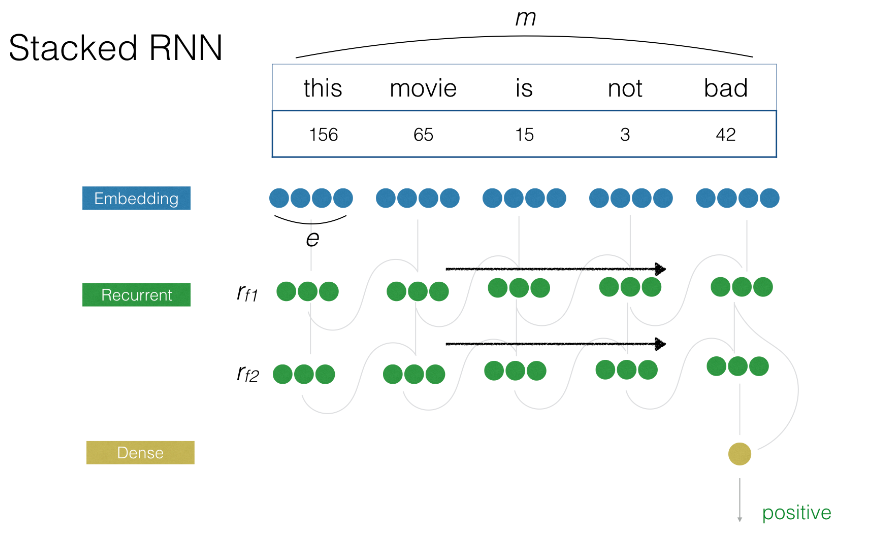

In [208]:
w2v_lstm_stacked = Sequential()
w2v_lstm_stacked.add(
    Embedding(
        VOCAB_SIZE, w2v_google.vectors.shape[1],
        mask_zero=True,
        weights=[embedding_weights_google],
        trainable=False
    )
)
w2v_lstm_stacked.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
w2v_lstm_stacked.add(Dropout(0.2))
w2v_lstm_stacked.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
w2v_lstm_stacked.add(Dropout(0.2))
w2v_lstm_stacked.add(Dense(1, activation='sigmoid'))
w2v_lstm_stacked.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [209]:
%%time

w2v_lstm_stacked.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
1193/1193 - 260s - loss: 0.5135 - accuracy: 0.7389 - val_loss: 0.4875 - val_accuracy: 0.7645
Epoch 2/20
1193/1193 - 256s - loss: 0.4660 - accuracy: 0.7705 - val_loss: 0.4196 - val_accuracy: 0.8054
Epoch 3/20
1193/1193 - 256s - loss: 0.4439 - accuracy: 0.7857 - val_loss: 0.4185 - val_accuracy: 0.8048
Epoch 4/20
1193/1193 - 256s - loss: 0.4272 - accuracy: 0.7955 - val_loss: 0.3931 - val_accuracy: 0.8220
Epoch 5/20
1193/1193 - 256s - loss: 0.4126 - accuracy: 0.8052 - val_loss: 0.3965 - val_accuracy: 0.8239
Epoch 6/20
1193/1193 - 255s - loss: 0.4020 - accuracy: 0.8106 - val_loss: 0.3754 - val_accuracy: 0.8310
Epoch 7/20
1193/1193 - 256s - loss: 0.3937 - accuracy: 0.8162 - val_loss: 0.3918 - val_accuracy: 0.8159
Epoch 8/20
1193/1193 - 256s - loss: 0.3857 - accuracy: 0.8196 - val_loss: 0.3782 - val_accuracy: 0.8254
Epoch 9/20
1193/1193 - 257s - loss: 0.3792 - accuracy: 0.8233 - val_loss: 0.3685 - val_accuracy: 0.8366
Epoch 10/20
1193/1193 - 258s - loss: 0.3705 - accuracy: 0.8287 -

In [210]:
for review in user_reviews:
    review_proba = make_prediction(w2v_lstm_stacked, review)
    row = {
        'model': 'w2v_lstm_stacked',
        'review': review,
        'pred_proba': review_proba
    }
    benchmark_df = benchmark_df.append(row, ignore_index=True)

benchmark_df[benchmark_df['model'] == 'w2v_lstm_stacked']

,model,review,pred_proba
25,w2v_lstm_stacked,Awesome film,0.993928
26,w2v_lstm_stacked,This film is bad!,0.008407
27,w2v_lstm_stacked,This film is not bad,0.430471
28,w2v_lstm_stacked,I think the movie is good,0.911111
29,w2v_lstm_stacked,I don't think the movie is good,0.349606


### Attention Mechanism
With an attention mechanism we no longer try encode the full sentence (document) into a fixed-length vector. Rather, we allow the classifier to “attend” to different parts of the sentence. Prediction now depends on a weighted combination of all the RNN states, not just the last state.

Later we can examine on what words model had attention and even summarize a text!
- Applying attention doesn't mean that it will increase the target metric
- What is often work, we can examine on what words our model pay attention to

In [31]:

# TODO: fix later
class AttentionLayer(Layer):
    '''
    Attention layer.
    '''

    def __init__(self, weights_initializer='glorot_uniform', **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.weights_initializer = weights_initializer


    def build(self, input_shape):
        self.Uw = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer=self.weights_initializer,
            trainable=True,
            name="attention_weights",
        )
        self.b = self.add_weight(
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True,
            name="attention_bias",
        )
        super(AttentionLayer, self).build(input_shape)


    def compute_mask(self, input, mask):
        return mask


    def call(self, x, mask=None):
        multData = K.exp(K.tanh(K.dot(x, self.Uw) + self.b))
        if mask is not None:
            multData = mask * multData
        output = multData / (K.sum(multData, axis=1) + K.epsilon())[:, None]
        return K.reshape(output, (K.shape(output)[0], K.shape(output)[1], 1))


    def get_output_shape_for(self, input_shape):
        newShape = list(input_shape)
        newShape[-1] = 1
        return tuple(newShape)

In [ ]:
wordsInputs = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32', name='words_input') # input 
emb = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True)(wordsInputs) # embedding layer
word_rnn = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(emb) # rnn layer
attention = AttentionLayer()(word_rnn) # attention layer
doc_emb = merge([word_rnn, attention], mode=lambda x: x[1] * x[0], output_shape=lambda x: x[0])
doc_emb = Lambda(lambda x: K.sum(x, axis=1), output_shape=lambda x: (x[0], x[2]))(doc_emb)
output = Dense(1, activation="sigmoid")(doc_emb)

attn_model = Model(input=[wordsInputs], output=[output])
attn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### References
- [Nice Repo](https://github.com/udsclub/workshop/blob/master/notebooks/UDS-workshop-rnn.ipynb)